In [2]:
import os
os.chdir(r'/content/drive/MyDrive/Work/PI_deepOnet_General/Posting/Darcy_flow')
import torch
import torch.autograd as autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.io
import math
import scipy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
import os
import csv
#from models import Green_transformer

class SimpleCSVLogger:
    def __init__(self, filepath):
        self.filepath = filepath

        # If the file doesn't exist, create one with headers.
        if not os.path.exists(filepath):
            with open(filepath, 'w', newline='') as csvfile:
                csvwriter = csv.writer(csvfile)
                csvwriter.writerow(['epoch', 'metric', 'value'])

    def log(self, epoch, metric, value):
        with open(self.filepath, 'a', newline='') as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow([epoch, metric, value])

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Data = scipy.io.loadmat('Data.mat')

Fs = torch.tensor(Data['Input'], dtype = torch.float32).to(device)
Y = torch.tensor(Data['Output'], dtype = torch.float32).to(device)

COOR = torch.tensor(Data['coors']).cuda()
coor  = COOR.repeat(len(Fs),1,1).float()

coorx = coor[:,:,0][:,:,None]
coory = coor[:,:,1][:,:,None]

Fs = Fs[:,:,None]
Y = Y[:,:,None]

Length = len(Fs)

torch.manual_seed(0)
np.random.seed(0)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
batch_size = 16

Length = int(0.4*Length)

x_data = Fs
cx_data = coorx
cy_data = coory
y_data = Y

x_train = x_data[0:int(0.8*Length),:,:]
cx_train = cx_data[0:int(0.8*Length),:,:]
cy_train = cy_data[0:int(0.8*Length),:,:]
y_train = y_data[0:int(0.8*Length),:,:]

x_test = x_data[int(0.8*Length):Length,:,:]
cx_test = cx_data[int(0.8*Length):Length,:,:]
cy_test = cy_data[int(0.8*Length):Length,:,:]
y_test = y_data[int(0.8*Length):Length,:,:]

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, cx_train, cy_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, cx_test, cy_test, y_test), batch_size=batch_size, shuffle=False)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [6]:
class MLP1(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                          nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                          nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                          nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                          nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class MLP2(nn.Module):
    def __init__(self,width_trunk, width_branch, length):
        super().__init__()
        layers = np.array([length,width_branch,width_branch,width_branch,width_branch,width_trunk])
        self.linears = torch.nn.Sequential(nn.Linear(layers[0],layers[1]), torch.nn.ReLU(),
                          nn.Linear(layers[1],layers[2]), torch.nn.ReLU(),
                          nn.Linear(layers[2],layers[3]), torch.nn.ReLU(),
                          nn.Linear(layers[3],layers[4]), torch.nn.ReLU(),
                          nn.Linear(layers[4],layers[5]))

    def forward(self,x):
        y = self.linears(x)
        return y

class DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(DeepOnet, self).__init__()

        self.encoder = nn.Linear(2, width_trunk) # input channel is 2: (a(x), x)
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLP = MLP1(width_trunk, width_branch, length)

    def forward(self, x, cx, cy):
        x = x.repeat(1,1,x.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x1 = self.MLP(x)

        c = torch.cat((cx,cy),dim=2)
        c = self.encoder(c)
        c = F.gelu(c)
        c = self.w1(c)
        c = F.gelu(c)
        c = self.w2(c)
        c = F.gelu(c)
        c = self.w3(c)
        c = F.gelu(c)
        c = self.w4(c)
        c = c*x1

        y = torch.sum(c,2)

        return y

class Ex_DeepOnet(nn.Module):
    def __init__(self, width_trunk, width_branch, length):
        super(Ex_DeepOnet, self).__init__()

        self.encoder = nn.Linear(2, width_trunk) # input channel is 2: (a(x), x)
        self.width_trunk = width_trunk
        self.w1 = torch.nn.Linear(width_trunk, width_trunk)
        self.w2 = torch.nn.Linear(width_trunk, width_trunk)
        self.w3 = torch.nn.Linear(width_trunk, width_trunk)
        self.w4 = torch.nn.Linear(width_trunk, width_trunk)
        self.MLPT = MLP2(width_trunk*5, width_branch, length)

    def forward(self, x, cx, cy):
        x = x.repeat(1,1,x.size(1)).permute(0,2,1)
        # print(x[0,:,:])
        # print(jj)
        x = self.MLPT(x)
        x1 = x[:,:,0*self.width_trunk:1*self.width_trunk]
        x2 = x[:,:,1*self.width_trunk:2*self.width_trunk]
        x3 = x[:,:,2*self.width_trunk:3*self.width_trunk]
        x4 = x[:,:,3*self.width_trunk:4*self.width_trunk]
        x5 = x[:,:,4*self.width_trunk:5*self.width_trunk]
        # print(x[0,:,:])
        c = torch.cat((cx,cy),dim=2)
        c = self.encoder(c)*x1
        c = F.gelu(c)
        c = self.w1(c)*x2
        c = F.gelu(c)
        c = self.w2(c)*x3
        c = F.gelu(c)
        c = self.w3(c)*x4
        c = F.gelu(c)
        c = self.w4(c)*x5

        y = torch.sum(c,2)

        return y


In [9]:
model = Ex_DeepOnet(width_trunk = 128, width_branch = 100, length = 1024).to(device, dtype = torch.float32)
print(count_parameters(model))
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
num_epochs = 300


for ep in range(num_epochs):
    model.train()
    t1 = default_timer()
    De_mse = 0
    train_l2 = 0
    ne = 0
    nt = 0
    for x, cx, cy, y in train_loader:
        ne += 1
        x, cx, cy, y = x.cuda(), cx.cuda(), cy.cuda(), y.cuda()

        optimizer.zero_grad()

        out = model(x,cx,cy)

        De = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))

        mse = De #+ Re

        mse.backward() # use the l2 relative loss
        optimizer.step()

        De_mse += De.item()

    scheduler.step()
    model.eval()
    test_mse = 0.0
    with torch.no_grad():
        for x, cx, cy, y in test_loader:
            nt += 1
            x, cx, cy, y = x.cuda(), cx.cuda(), cy.cuda(), y.cuda()

            out = model(x,cx,cy)
            test_mse += F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    De_mse /= ne
    test_mse /= nt

    t2 = default_timer()
    print(ep, t2-t1, De_mse, test_mse)


263872
0 1.728292539999984 0.10625271886587143 0.10333030924201012
1 1.7292742970000745 0.09131219798699021 0.04036365501582623
2 1.7285027880000143 0.015996211478486656 0.012380389105528593
3 1.7290286479999395 0.009277421284932643 0.0072124409582465885
4 1.7293123949998517 0.006148122830782085 0.005063629844225943
5 1.7334620719998384 0.004531752085313201 0.004358084974810481
6 1.7292791679999482 0.003971106315730139 0.003342055776156485
7 1.7318150220000916 0.0031513964640907943 0.003042480298317969
8 1.737760488000049 0.0029224162513855844 0.0029430146748200057
9 1.7309516739999253 0.002707462521502748 0.0025759724387899043
10 1.7395919279999816 0.0025066534348297865 0.0027342279767617584
11 1.7315725650000786 0.0023727472528116775 0.0023472786229103803
12 1.7312690599999314 0.0022326236782828344 0.0024959712754935026
13 1.7317851729999347 0.0021761371131287888 0.002054611111525446
14 1.7302084380000906 0.0019804728892631827 0.002068752399645746
15 1.7311821309999686 0.001908555640

KeyboardInterrupt: ignored

0.0034439180001299974


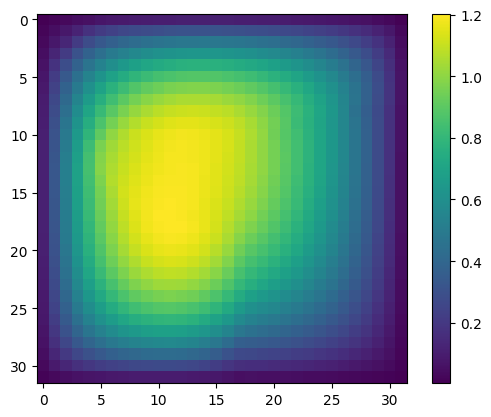

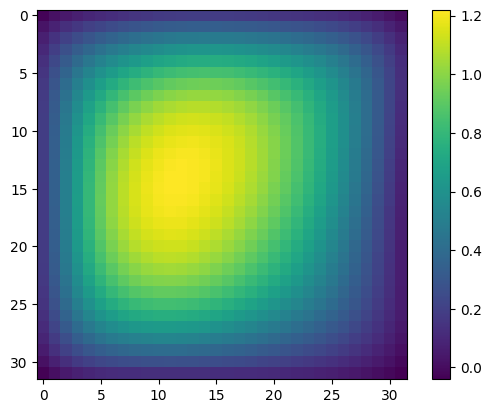

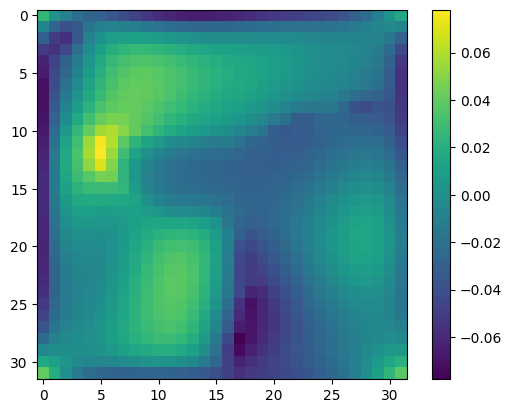

In [10]:
k = 100
x = x_test[k,:,:][None,:,:].cuda()
cx = cx_test[k,:,:][None,:,:].cuda()
cy = cy_test[k,:,:][None,:,:].cuda()
y = y_test[k,:,:][None,:,:].cuda()
# x = torch.ones(1,n,1).cuda() + 10
t1 = default_timer()
out = model(x,cx,cy).squeeze().cpu()
t2 = default_timer()
print(t2-t1)

yt = y.squeeze().cpu()
yt = y.squeeze().cpu()
yp = out.squeeze().cpu()
num = int((len(yt))**0.5)

yt = torch.reshape(yt,(num,num))
yp = torch.reshape(yp,(num,num))

plt.figure(1)
plt.imshow(yt)
plt.colorbar()
plt.figure(2)
plt.imshow(yp.detach().numpy())
plt.colorbar()
plt.figure(3)
plt.imshow((yt-yp.detach().numpy())/torch.max(yt))
plt.colorbar()